In [1]:
import os
os.chdir('..')
os.getcwd()

'/home/abraham-pc/Documents/paid_gigs/malaria_prediction_cv'

In [2]:
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense, Multiply, Reshape, Attention, Flatten, Dropout, Add, Permute
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16, ResNet50, VGG19, EfficientNetB7, densenet
import tensorflow_addons as tfa
from keras_self_attention import SeqSelfAttention 
import attention as attn
import mlflow
import random
# Set seeds to make the experiment more reproducible.
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'


2024-01-19 16:03:12.621499: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-19 16:03:12.651605: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 16:03:12.651640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 16:03:12.652469: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 16:03:12.658017: I tensorflow/core/platform/cpu_feature_guar

In [4]:
from src.features.build_features import X_train, y_train, X_test, y_test, X_val, y_val, transform_data

In [5]:
def configure_gpu():

    try:
        gpus = tf.config.list_physical_devices('GPU')
        print(f"Found {len(gpus)} GPU(s): {gpus}")
    except Exception as e:
        print("Error configuring GPU: \n", e)
        print("Training will run on CPU")

    if gpus: # type: ignore
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Memory growth enabled for all Physical GPUs")
        except Exception as e:
            print("Error configuring memory growth: \n", e)

configure_gpu()

Found 1 GPU(s): [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Memory growth enabled for all Physical GPUs


2024-01-19 16:03:21.637521: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-19 16:03:21.663043: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-19 16:03:21.663248: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
# Define the model
def squeeze_excite_block(input_tensor, ratio=8):
    # Squeeze operation
    squeeze = GlobalAveragePooling2D()(input_tensor)

    # Excitation operation
    excitation = Dense(input_tensor.shape[-1] // ratio, activation='relu')(squeeze)
    excitation = Dense(input_tensor.shape[-1], activation='sigmoid')(excitation)
    excitation = Reshape((1, 1, -1))(excitation)

    # Scale the input tensor
    scaled_input = Multiply()([input_tensor, excitation])

    return scaled_input


def convolutional_block_attention_module(input_tensor, ratio=8):
    # Channel attention
    channel_avg = GlobalAveragePooling2D()(input_tensor)
    channel_max = GlobalAveragePooling2D()(input_tensor)
    channel_shared = Dense(input_tensor.shape[-1] // ratio, activation='relu', kernel_regularizer=regularizers.l2(0.01))(channel_avg) + \
                     Dense(input_tensor.shape[-1] // ratio, activation='relu', kernel_regularizer=regularizers.l2(0.01))(channel_max)
    channel_attention = Dense(input_tensor.shape[-1], activation='sigmoid', kernel_regularizer=regularizers.l2(0.01))(channel_shared)
    channel_attention = Reshape((1, 1, -1))(channel_attention)

    # Spatial attention
    spatial_avg = Reshape((1, 1, input_tensor.shape[-1]))(GlobalAveragePooling2D()(input_tensor))
    spatial_max = Reshape((1, 1, input_tensor.shape[-1]))(GlobalAveragePooling2D()(input_tensor))
    spatial_shared = Add()([Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.01))(spatial_avg),
                           Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.01))(spatial_max)])
    spatial_attention = Activation('sigmoid')(spatial_shared)

    # Combine channel and spatial attention
    attention = Multiply()([input_tensor, channel_attention, spatial_attention])

    return attention


def build_dilated_cnn_with_attention(input_shape, num_classes, dilation_rate, attention_units, ratio):
    # Load pre-trained VGG16 model without top (fully connected) layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze pre-trained layers
    for layer in base_model.layers:
        layer.trainable = False

    # Get output tensor of the last VGG16 layer
    x = base_model.output

    conv1 = Conv2D(filters = 64, dilation_rate = dilation_rate, kernel_size = (3, 3), activation = 'relu', padding='same')(x)
    maxpool1 = MaxPooling2D(pool_size = (2, 2), strides=(2, 2))(conv1)

    # attn1 = Attention(maxpool1, ))

    conv2 = Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding='same')(maxpool1)
    maxpool2 = MaxPooling2D(pool_size = (2, 2), strides=(2, 2))(conv2)

    conv3 = Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding='same')(maxpool2)
    maxpool3 = MaxPooling2D(pool_size = (1, 1), strides=(2, 2))(conv3)

    attn = Attention(attention_units)([maxpool3, maxpool3])
    # attn = squeeze_excite_block(input_tensor=maxpool3, ratio=ratio)

    flattened = Flatten()(attn)

    fc1 = Dense(units = 512, activation = 'relu')(flattened)
    drop1 = Dropout(rate = 0.5)(fc1)

    final = Dense(units = num_classes,activation='sigmoid')(drop1)

    model = Model(inputs=base_model.input, outputs=final)

    return model

In [7]:
mechs = {
    'SA': 0,
    'SE': 1,
    'CBAM': 2
}

# Parameters
input_shape = (224, 224, 3)
input_transform = 0
num_classes = 4
num_epochs = 100
lr = 0.001
batch_size = 16
patience = 20
val_split = 0.2
dil = 4
dilation_rate = (dil, dil)
ratio = 0
attention_mechanism = mechs['SA']
attention_units = 512

In [8]:
if input_transform == 1:
    X_train = transform_data(X_train, modify=True)
    X_val = transform_data(X_val)
    X_test = transform_data(X_test)
else:
    X_train = transform_data(X_train)
    X_val = transform_data(X_val)
    X_test = transform_data(X_test)

In [9]:
# Build the model
model = build_dilated_cnn_with_attention(input_shape, num_classes, dilation_rate, attention_units, ratio)


# Compile the model and print a summary
model.compile(optimizer=Adam(lr), loss='categorical_crossentropy', metrics=['accuracy',
                                                                            tfa.metrics.F1Score(average='macro', num_classes=4),
                                                                            tf.keras.metrics.Precision(),
                                                                            tf.keras.metrics.Recall()])
model.summary()

2024-01-19 16:03:21.884090: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-19 16:03:21.884365: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-19 16:03:21.884492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [10]:
def testdata_evaluation(model, X_test, y_test):
    actual = np.argmax(y_test, axis=1)
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(actual, predictions)
    f1_weighted = f1_score(actual, predictions, average='weighted')
    return float(accuracy), float(f1_weighted)

# def testdata_evaluation(model, test_generator, y_test):
#     actual = np.argmax(y_test, axis=1)
#     preds = model.predict(test_generator)
#     predictions = np.argmax(preds, axis=1)
#     accuracy = accuracy_score(actual, predictions)
#     f1_weighted = f1_score(actual, predictions, average='weighted')
#     return float(accuracy), float(f1_weighted)

def k_fold_evaluation(model, X_test, y_test, folds=5):
    kf = StratifiedKFold(n_splits=folds)

    f1_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    y_test = np.argmax(y_test, axis=1)

    for _, test_index in kf.split(X_test, y_test):
        features = X_test[test_index]
        actual = y_test[test_index]
        predictions = model.predict(features, verbose=0)
        predictions = np.argmax(predictions, axis=1)
        f1_scores.append(f1_score(actual, predictions, average='weighted', zero_division=0))
        accuracy_scores.append(accuracy_score(actual, predictions))
        precision_scores.append(precision_score(actual, predictions, average='weighted', zero_division=0))
        recall_scores.append(recall_score(actual, predictions, average='weighted', zero_division=0))

    f1_weighted = float(np.mean(f1_scores))
    accuracy = float(np.mean(accuracy_scores))
    precision = float(np.mean(precision_scores))
    recall = float(np.mean(recall_scores))

    return f1_weighted, accuracy, precision, recall
    

In [11]:
# Define the MLflow experiment
experiment_name = "exp9_4_SA_512"
experiment = mlflow.set_experiment(experiment_name)

# Define paths
checkpoint_dir = './models/checkpoints/'
model_file = f'./models/model_{experiment_name+experiment.experiment_id}.keras'
os.makedirs( checkpoint_dir + experiment_name, exist_ok=True)
checkpoint_file = checkpoint_dir + experiment_name

# define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score', 
    patience=patience, 
    mode='max',
    restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_file, 
    monitor="val_f1_score",
    mode="max", 
    save_best_only=True,
    verbose=0
)

# Train the model
mlflow.tensorflow.autolog()
with mlflow.start_run(experiment_id=experiment.experiment_id) as run:
    mlflow.log_params({
        "learning_rate": lr,
        "dilation_rate": dilation_rate,
        "attention_units": attention_units,
        "ratio": ratio,
        "attention_mechanism": attention_mechanism,
        "num_classes": num_classes,
        "input_shape": input_shape,
        "input_transform": input_transform,
        "batch_size": batch_size,
        "patience": patience,
        "num_epochs": num_epochs,
        "val_split": val_split
    })

    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=num_epochs,
        callbacks=[
            early_stopping,
            checkpoint
        ]
    )
    model.save(model_file)
    
    test_model = tf.keras.models.load_model(checkpoint_file)
    f1_weighted, accuracy, precision, recall = k_fold_evaluation(test_model, X_test, y_test, folds=5)

    mlflow.log_metrics({
        "test accuracy": accuracy,
        "test f1_weighted": f1_weighted,
        "test precision": precision,
        "test recall": recall
    })
    mlflow.log_artifact(model_file)


2024-01-19 16:03:22.645738: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/100


2024-01-19 16:03:23.844861: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-19 16:03:23.914206: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-19 16:03:24.715764: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff3ad750c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-19 16:03:24.715785: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-01-19 16:03:24.719995: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705676604.791242   21990 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9/9 [==============================] - ETA: 0s - loss: 1.3034 - accuracy: 0.3681 - f1_score: 0.3009 - precision: 0.3544 - recall: 0.5833INFO:tensorflow:Assets written to: ./models/checkpoints/exp9_4_SA_512/assets


INFO:tensorflow:Assets written to: ./models/checkpoints/exp9_4_SA_512/assets


9/9 [==============================] - 5s 297ms/step - loss: 1.3034 - accuracy: 0.3681 - f1_score: 0.3009 - precision: 0.3544 - recall: 0.5833 - val_loss: 1.3037 - val_accuracy: 0.3333 - val_f1_score: 0.1250 - val_precision: 0.3684 - val_recall: 0.3889
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 1.0967 - accuracy: 0.4931 - f1_score: 0.3628 - precision: 0.4337 - recall: 0.7500INFO:tensorflow:Assets written to: ./models/checkpoints/exp9_4_SA_512/assets


INFO:tensorflow:Assets written to: ./models/checkpoints/exp9_4_SA_512/assets


9/9 [==============================] - 2s 254ms/step - loss: 1.0967 - accuracy: 0.4931 - f1_score: 0.3628 - precision: 0.4337 - recall: 0.7500 - val_loss: 0.9056 - val_accuracy: 0.6111 - val_f1_score: 0.4765 - val_precision: 0.4146 - val_recall: 0.9444
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 0.7462 - accuracy: 0.6736 - f1_score: 0.5790 - precision: 0.4228 - recall: 0.9514INFO:tensorflow:Assets written to: ./models/checkpoints/exp9_4_SA_512/assets


INFO:tensorflow:Assets written to: ./models/checkpoints/exp9_4_SA_512/assets


9/9 [==============================] - 2s 233ms/step - loss: 0.7462 - accuracy: 0.6736 - f1_score: 0.5790 - precision: 0.4228 - recall: 0.9514 - val_loss: 0.6593 - val_accuracy: 0.7500 - val_f1_score: 0.6186 - val_precision: 0.4595 - val_recall: 0.9444
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 0.6017 - accuracy: 0.7431 - f1_score: 0.7524 - precision: 0.4781 - recall: 0.9861INFO:tensorflow:Assets written to: ./models/checkpoints/exp9_4_SA_512/assets


INFO:tensorflow:Assets written to: ./models/checkpoints/exp9_4_SA_512/assets


9/9 [==============================] - 2s 253ms/step - loss: 0.6017 - accuracy: 0.7431 - f1_score: 0.7524 - precision: 0.4781 - recall: 0.9861 - val_loss: 0.6317 - val_accuracy: 0.8333 - val_f1_score: 0.8334 - val_precision: 0.4658 - val_recall: 0.9444
Epoch 5/100
9/9 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.9167 - f1_score: 0.9309 - precision: 0.5180 - recall: 1.0000INFO:tensorflow:Assets written to: ./models/checkpoints/exp9_4_SA_512/assets


INFO:tensorflow:Assets written to: ./models/checkpoints/exp9_4_SA_512/assets


9/9 [==============================] - 2s 227ms/step - loss: 0.2903 - accuracy: 0.9167 - f1_score: 0.9309 - precision: 0.5180 - recall: 1.0000 - val_loss: 0.6614 - val_accuracy: 0.8611 - val_f1_score: 0.8703 - val_precision: 0.5667 - val_recall: 0.9444
Epoch 6/100
9/9 [==============================] - 1s 99ms/step - loss: 0.1819 - accuracy: 0.9167 - f1_score: 0.9300 - precision: 0.6076 - recall: 1.0000 - val_loss: 0.7958 - val_accuracy: 0.7778 - val_f1_score: 0.7910 - val_precision: 0.5667 - val_recall: 0.9444
Epoch 7/100
9/9 [==============================] - 1s 99ms/step - loss: 0.1343 - accuracy: 0.9375 - f1_score: 0.9420 - precision: 0.5830 - recall: 1.0000 - val_loss: 0.7465 - val_accuracy: 0.8333 - val_f1_score: 0.8355 - val_precision: 0.5763 - val_recall: 0.9444
Epoch 8/100
9/9 [==============================] - 1s 99ms/step - loss: 0.1140 - accuracy: 0.9583 - f1_score: 0.9625 - precision: 0.6575 - recall: 1.0000 - val_loss: 0.7582 - val_accuracy: 0.8611 - val_f1_score: 0.8519 

INFO:tensorflow:Assets written to: ./models/checkpoints/exp9_4_SA_512/assets


9/9 [==============================] - 2s 254ms/step - loss: 0.0120 - accuracy: 1.0000 - f1_score: 1.0000 - precision: 0.8421 - recall: 1.0000 - val_loss: 0.7920 - val_accuracy: 0.8889 - val_f1_score: 0.8797 - val_precision: 0.6875 - val_recall: 0.9167
Epoch 14/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0041 - accuracy: 1.0000 - f1_score: 1.0000 - precision: 0.8571 - recall: 1.0000 - val_loss: 0.8550 - val_accuracy: 0.8889 - val_f1_score: 0.8797 - val_precision: 0.7333 - val_recall: 0.9167
Epoch 15/100
9/9 [==============================] - 1s 99ms/step - loss: 0.0013 - accuracy: 1.0000 - f1_score: 1.0000 - precision: 0.8623 - recall: 1.0000 - val_loss: 0.8691 - val_accuracy: 0.8889 - val_f1_score: 0.8797 - val_precision: 0.7556 - val_recall: 0.9444
Epoch 16/100
9/9 [==============================] - 1s 98ms/step - loss: 0.0011 - accuracy: 1.0000 - f1_score: 1.0000 - precision: 0.9000 - recall: 1.0000 - val_loss: 0.9625 - val_accuracy: 0.8889 - val_f1_score: 0.87

INFO:tensorflow:Assets written to: /tmp/tmpj4y4ucq0/model/data/model/assets


In [12]:
# test_model_file = f'./models/model_DCA_first_try453954341690039783.keras'
# test_model_file = f'./models/checkpoints/DCA_first_try'

# test_model = tf.keras.models.load_model(checkpoint_file)
# test_model = tf.keras.models.load_model(test_model_file)

In [13]:
# model_name = 'exp9_4_SA_512'

# test_model_file = f'./models/model_exp15_2_SE_16948774673636091947.keras'
# test_model = tf.keras.models.load_model(test_model_file, custom_objects={"f1_score": tfa.metrics.F1Score(num_classes=4)})

In [14]:
# Classification Report for each type of attack
def print_f1_scores(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)

    for class_label, metric in report.items():
        try:
            f1_score_float = metric['f1-score']
            print(f"Class {class_label}: F1-score = {round(f1_score_float, 3)}")
        except:
            pass

In [15]:
# def print_testdata_evaluation(model, train_generator, test_generator, test_df):
#     mapping = train_generator.class_indices
#     actual = test_df['species'].map(mapping)
#     preds = model.predict(test_generator)
#     predictions = np.argmax(preds, axis=1)
#     accuracy = accuracy_score(actual, predictions)
#     # f1_weighted = f1_score(actual, predictions, average='weighted')
#     print_f1_scores(actual, predictions)
#     print(f"Test accuracy = {accuracy}")

def print_newdata_evaluation(model, X_test, y_test):
    actual = np.argmax(y_test, axis=1)
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(actual, predictions)
    f1_weighted = f1_score(actual, predictions, average='weighted')
    print_f1_scores(actual, predictions)
    print(f"Test accuracy = {accuracy}")

In [16]:
# print_newdata_evaluation(test_model, X_test, y_test)

In [17]:
def k_fold_evaluation(model, X_test, y_test, folds=5):
    kf = StratifiedKFold(n_splits=folds)

    f1_scores = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    y_test = np.argmax(y_test, axis=1)

    for _, test_index in kf.split(X_test, y_test):
        features = X_test[test_index]
        actual = y_test[test_index]
        predictions = model.predict(features, verbose=0)
        predictions = np.argmax(predictions, axis=1)
        f1_scores.append(f1_score(actual, predictions, average='weighted', zero_division=0))
        accuracy_scores.append(accuracy_score(actual, predictions))
        precision_scores.append(precision_score(actual, predictions, average='weighted', zero_division=0))
        recall_scores.append(recall_score(actual, predictions, average='weighted', zero_division=0))

    f1_weighted = np.mean(f1_scores)
    accuracy = np.mean(accuracy_scores)
    precision = np.mean(precision_scores)
    recall = np.mean(recall_scores)

    return f1_weighted, accuracy, precision, recall

In [18]:
k_fold_evaluation(model, X_test, y_test)

(0.8916931216931218,
 0.9111111111111111,
 0.8955555555555555,
 0.9111111111111111)

In [19]:
predictions = model.predict(X_test, verbose=0)
predictions = np.argmax(predictions, axis=1)
actual = np.argmax(y_test, axis=1)


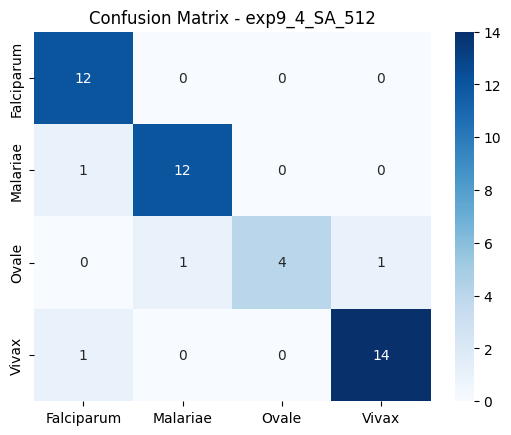

In [20]:
# confusion_matrix(actual, predictions)
species = ['Falciparum', 'Malariae', 'Ovale', 'Vivax']


sns.heatmap(confusion_matrix(actual, predictions), annot=True, cmap='Blues', fmt='g', xticklabels=species, yticklabels=species)

plt.title(f"Confusion Matrix - {experiment_name}")
plt.savefig(f'./reports/figures/confusion_matrix_{experiment_name}.png')
plt.show()